# Importing libraries and downloading dataset

In [86]:
import glob
import cv2
import torch.nn as nn 
import os
import torch
import copy
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision
import torchvision.transforms as transforms 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


# Hyperparameters

In [87]:
batch_size = 4

In [88]:
# path = kagglehub.dataset_download("nickj26/places2-mit-dataset") + 'versions/2/test_256/test_256'
train_path = '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train'
test_path = '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/test'
print("Path to dataset files:", train_path)

Path to dataset files: /home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train


## Size of training batch

In [89]:
file_names = glob.glob(train_path + '/*.jpg')

print(len(file_names))
print(file_names[:10])

328168
['/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00067829.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00005034.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00241834.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00017812.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00203406.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00184281.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00317614.jpg', '/home/manjot/.cache/kagglehub/datasets/nickj26/places2-mit-dataset/versions/2/test_256/train/Places365_test_00299825.jpg', 

# Data preprocessing

In [90]:
class Placesdataset(Dataset):
    def __init__(self, dir_path, image_dim=(256,256),n_channels=3, mask_iterations = 5):
        self.file_names = glob.glob(dir_path + '/*.jpg')
        self.img_dim = image_dim
        self.to_tensor = transforms.ToTensor()
        self.channels = n_channels
        self.iterations = mask_iterations
        self.resize = transforms.Resize(image_dim)

    def __getitem__(self, idx):
        image = Image.open(self.file_names[idx]).convert("RGB")
        Y_output = self.resize(image)
        X_input, X_mask = self.create_mask(Y_output)
        X_input = self.to_tensor(X_input)
        X_mask = self.to_tensor(X_mask)
        Y_output = self.to_tensor(Y_output)
        return X_input, X_mask, Y_output

        

    def __len__(self):
        return len(self.file_names)
    
    def line_generator(self, image):
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            pt2 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            thickness =np.random.randint(10, 15)
            
            cv2.line(image, pt1=pt1, pt2=pt2, color=(1,1,1), thickness=thickness)

    def circle_generator(self, image):
        for _ in range(self.iterations):
            pt1 = (np.random.randint(0,self.img_dim[0]),np.random.randint(0,self.img_dim[1]))
            radius =np.random.randint(5, 25)

            cv2.circle(image,pt1,radius,(1,1,1), -1)

    def create_mask(self, image):
        mask = np.full((self.img_dim[0], self.img_dim[1], self.channels), 255, dtype=np.uint8)
        self.line_generator(mask)
        self.circle_generator(mask)

        image = np.asarray(image)
        masked_image = cv2.bitwise_and(image, mask)
        return masked_image, mask

In [91]:
Training_Data = Placesdataset(train_path)

Training_Loader = torch.utils.data.DataLoader(Training_Data, batch_size, shuffle=True)

Train_Iter = iter(Training_Loader)


torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256]) torch.Size([4, 3, 256, 256])
Masked Image


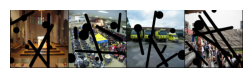

Masking Pattern


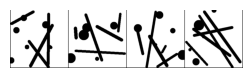

Original Image


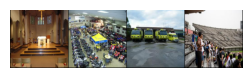

In [92]:
X_in, X_mask, Y_out = Train_Iter._next_data()
print(X_in.shape, X_mask.shape, Y_out.shape)

def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# Model Architecture

![Architecture](Places-2-network-architecture.png)

In [93]:
class Partial_Conv(nn.Module):
    def __init__(self, input_filters, output_filters, kernel_size=(3,3),stride=1, bias=True, groups=1,dilation=1, bn=True):
        super().__init__()
        self.bn = bn
        padding = (kernel_size[0]//2, kernel_size[1]//2)
        self.input_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups,bias)
        self.mask_conv = nn.Conv2d(input_filters,output_filters,kernel_size,stride,padding,dilation,groups, False)

        self.window_size = kernel_size[0]*kernel_size[1]
        nn.init.constant_(self.mask_conv.weight, 1.0)
        nn.init.kaiming_normal_(self.input_conv.weight, a = 0, mode='fan_in')

        if self.bn:
            self.bath_normalization = nn.BatchNorm2d(output_filters)
        for param in self.mask_conv.parameters():
            param.requires_grad = False
    
    def forward(self, input, mask):
        output = self.input_conv(input * mask)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)
        output_mask = torch.clamp(output_mask, 0, 1)
        mask_ratio = mask_ratio * output_mask
        output = output * mask_ratio


        return output, output_mask

In [94]:
class EncodingLayer(nn.Module):
    def __init__(self, in_filters, out_filters, kernel=3, stride=1, bias=False, bn=True):
        super().__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.activation = nn.ReLU()
        self.conv = Partial_Conv(self.in_filters, self.out_filters,(kernel,kernel),stride, bias = bias, bn=bn)

    def forward(self, input, input_mask):
        output, output_mask = self.conv(input, input_mask)
        output = self.activation(output)
        return output, output_mask


In [95]:
class DecodingLayer(nn.Module):
    def __init__(self, in_filters, out_filters, bn=True, activation=True, bias=False):
        super().__init__()
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.up_image = nn.Upsample(scale_factor=(2,2))
        self.up_mask = nn.Upsample(scale_factor=(2,2))
        self.activate = activation
        self.conv = Partial_Conv(self.in_filters, self.out_filters, bias=bias,bn=bn)
        self.act = nn.LeakyReLU(negative_slope=0.2)
    
    def forward(self, input_image, input_mask, shared_image, shared_mask):
        upscaled_image = F.interpolate(input_image, scale_factor=2)
        upscaled_mask = F.interpolate(input_mask, scale_factor=2)
        combined_image = torch.cat([upscaled_image, shared_image], dim=1)
        combined_mask = torch.cat([upscaled_mask, shared_mask], dim=1)
        output_image, output_mask = self.conv(combined_image, combined_mask)
        if self.activate:
            output_image = self.act(output_image)
        return output_image, output_mask


    


In [96]:
class PartialConvUNet(nn.Module):
    def __init__(self, input_size = 256, layers = 7):
        if 2**(layers + 1) != input_size:
            raise AssertionError
        super().__init__()
        self.layers = layers 
        self.encoder_1 = EncodingLayer(3, 64, 7, 2, bn=False)
        self.encoder_2 = EncodingLayer(64, 128, 5, 2)
        self.encoder_3 = EncodingLayer(128, 256, 3, 2)
        self.encoder_4 = EncodingLayer(256, 512, 3, 2)

        for i in range(5, layers + 1):
            name = f"encoder_{i}"
            setattr(self, name, EncodingLayer(512, 512, 3, 2))

        for i in range(5, layers + 1):
            name = f"decoder_{i}"
            setattr(self, name, DecodingLayer(512+512, 512))

        self.decoder_4 = DecodingLayer(512 + 256, 256)
        self.decoder_3 = DecodingLayer(256 + 128, 128)
        self.decoder_2 = DecodingLayer(128 + 64, 64)
        self.decoder_1 = DecodingLayer(64 + 3, 3, bn=False, activation=False, bias=True)

    def forward(self, input_x, mask):
        encoder_dict = {}
        mask_dict = {}
        key_prev = "h_0"
        encoder_dict[key_prev], mask_dict[key_prev] = input_x, mask

        for i in range(1, self.layers + 1):
            encoder_key = f'encoder_{i}'
            key = f"h_{i}"
            encoder_dict[key], mask_dict[key] = getattr(self, encoder_key)(encoder_dict[key_prev], mask_dict[key_prev])
            key_prev = key
        
        out_key = f"h_{self.layers}"
        out_data, out_mask = encoder_dict[out_key], mask_dict[out_key]

        for i in range(self.layers, 0, -1):
            encoder_key = f"h_{i-1}"
            decoder_key = f"decoder_{i}"
            out_data, out_mask = getattr(self, decoder_key)(out_data, out_mask, encoder_dict[encoder_key], mask_dict[encoder_key])
        return out_data



        

Min loss: 0.3480
Iteration 0/82042.0, Loss: 0.3480
Min loss: 0.2370
Min loss: 0.2075
Min loss: 0.1998
Min loss: 0.1964
Min loss: 0.1747
Min loss: 0.1703
Min loss: 0.1486
Min loss: 0.1208
Min loss: 0.1171
Min loss: 0.1047
Min loss: 0.0882
Min loss: 0.0766
Min loss: 0.0763
Min loss: 0.0551
Min loss: 0.0488
Min loss: 0.0198
Iteration 100/82042.0, Loss: 0.0387
Min loss: 0.0181
Min loss: 0.0162
Iteration 200/82042.0, Loss: 0.0393
Iteration 300/82042.0, Loss: 0.0253
Min loss: 0.0122
Iteration 400/82042.0, Loss: 0.0274
Iteration 500/82042.0, Loss: 0.0196
Min loss: 0.0121
Iteration 600/82042.0, Loss: 0.0152
Min loss: 0.0118
Min loss: 0.0088
Iteration 700/82042.0, Loss: 0.0198
Iteration 800/82042.0, Loss: 0.0168
Iteration 900/82042.0, Loss: 0.0191
Iteration 1000/82042.0, Loss: 0.0184
Iteration 1100/82042.0, Loss: 0.0103
Min loss: 0.0081
Iteration 1200/82042.0, Loss: 0.0138
Iteration 1300/82042.0, Loss: 0.0158
Iteration 1400/82042.0, Loss: 0.0150
Iteration 1500/82042.0, Loss: 0.0233
Iteration 16

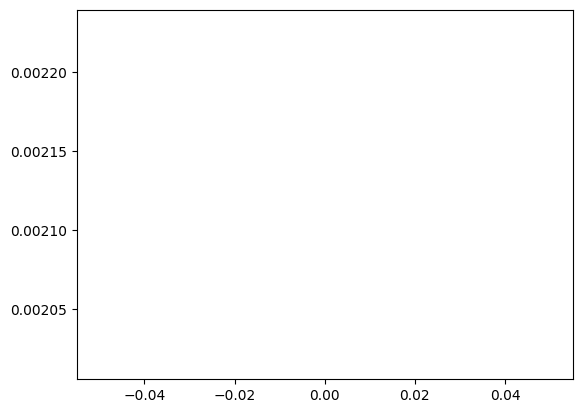

In [97]:
model = PartialConvUNet().to(device)
loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

loss_epoch_arr = []
max_epochs = 1
min_loss = 1000
n_iters = np.ceil(len(Training_Loader))
for epoch in range(max_epochs):
    model.train()
    for i, (x_input, x_mask, y_output) in enumerate(Training_Loader):
        x_input, x_mask, y_output = x_input.to(device), x_mask.to(device), y_output.to(device)
        opt.zero_grad()

        outputs = model(x_input, x_mask)
        loss = loss_fn(y_output, outputs)
        loss.backward()
        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print(f'Min loss: {min_loss:.4f}')

        if not i%100:
            print(f'Iteration {i}/{n_iters}, Loss: {loss.item():.4f}')
        
    loss_epoch_arr.append(loss.item())

plt.plot(loss_epoch_arr)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.08129889..1.143416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027447267..1.0922352].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.115389846..1.2374275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.085609004..1.1551478].


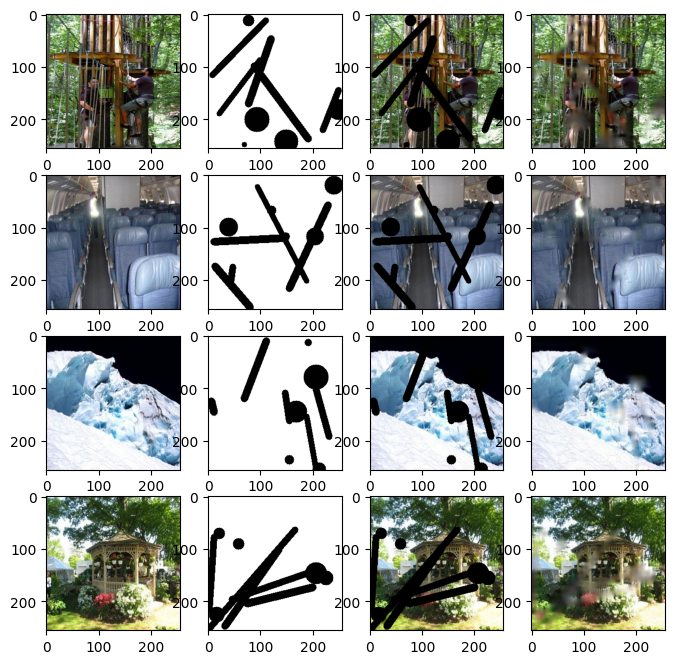

In [120]:
model.load_state_dict(best_model)

sample_inputs, sample_masks, sample_truths = Train_Iter._next_data()
sample_inputs, sample_masks = sample_inputs.cuda(), sample_masks.cuda()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))


In [ ]:
print()